# Sticking to the Target

### 1. Import Libraries

In [2]:
from unityagents import UnityEnvironment
import numpy as np

import random
import torch
import time
from collections import deque
import matplotlib.pyplot as plt
from workspace_utils import active_session
%matplotlib inline

# Custom RL Agent
from agent import Agent

### 2. Create the Unity Environment

Using the Reacher environment, a unity agents 'brain' is created, which is responsible for deciding the agents actions. 

In [3]:
# Set environment and display information
env = UnityEnvironment(file_name='Reacher.app')

# Set the default ReacherBrain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 3. Train the Agent

#### Training Implementation
An `ddpg_training` function is used for implementating the training for each agent and stores the best weights of the model once an average score of 30 or more has been achieved across all 20 agents.

This algorithm consists of a Deep Deterministic Policy Gradient (DDPG) with the Ornstein-Uhlenbeck process, to create noise within the network and Experience Replay.

#### DDPG Architecture
- An _actor_ consisting of a fully-connected network (4 layers):
    - An input layer with 33 inputs, representing the state size
    - 2 hidden layers, both with 128 hidden nodes that are passed through relu activation functions
    - An output layer with 4 outputs, for the number of actions, passed through a tanh activation function


- A _critic_ consisting of a fully-connected network (4 layers):
    - An input layer with 33 inputs, representing the state size
    - 2 hidden layers, one with 132 hidden nodes (128 + actions) and the other with 128 hidden nodes that are passed through relu activation functions
    - An output layer with 1 output, specifying the Q-value

#### Hyperparameters Used
- `BUFFER_SIZE = int(1e5)`: replay buffer size
- `BATCH_SIZE = 256`: minibatch size
- `GAMMA = 0.99`: discount factor
- `TAU = 1e-3`: used for soft update of target parameters
- `LR_ACTOR = 1e-3`: learning rate of the actor
- `LR_CRITIC = 1e-3`: learning rate of the critic
- `EPS_START = 1`: epsilon start value
- `EPS_END = 0.05`: epsilon ending value
- `EPS_DECAY = 1e-6`: epsilon decay rate
- `UPDATE_EVERY = 20`: num timesteps before each update
- `NUM_UPDATE = 10`: num of updates after set num of timesteps

In [4]:
def ddpg_training(brain_name, n_agents, n_episodes=1000, 
                  max_t=1000, print_every=100):
    """
    Perform DDPG training on each agent.
    
    Parameters:
      - brain_name (string): name of agent brain to use
      - n_agents (int): number of agents
      - n_episodes (int): maximum number of training episodes
      - max_t (int): maximum number of timesteps per episode
      - print_every (int): number of scores to average
    """
    scores_list = []  # list containing scores from each episode
    scores_window = deque(maxlen=print_every) # last set of scores
    
    # Iterate over each episode
    for i_episode in range(1, n_episodes+1):
        # Reset environment and agents, set initial states
        # and reward scores every episode
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        states = env_info.vector_observations
        scores = np.zeros(n_agents)
        
        # Iterate over each timestep
        for t in range(max_t):
            # Perform an action for each agent in the environment
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            
            # Set new experiences and interact with the environment
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agent.step(states, actions, rewards, next_states, dones, t)
            
            # Update states and scores
            states = next_states
            scores += rewards
            
            # Break loop if an agent finishes the episode
            if any(dones):
                break 
        
        # Save most recent scores
        scores_window.append(np.mean(scores))
        scores_list.append(np.mean(scores))
        
        # Output episode information
        print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}', end="")
        if i_episode % print_every == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}')
        
        # Save environment if goal achieved
        if np.mean(scores_window) >= 30.0:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_window):.2f}')
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
            break
            
    # Return reward scores
    return scores_list

In [5]:
# Initialize the environment
env_info = env.reset(train_mode=True)[brain_name]

# Set number of actions
action_size = brain.vector_action_space_size # 4

# Set states for each agent
states = env_info.vector_observations
state_size = states.shape[1] # 33

# Set number of agents
num_agents = len(env_info.agents) # 20
print(f'Number of agents: {num_agents}')

# Create and view the agent networks
agent = Agent(state_size, action_size, seed=0, n_agents=num_agents)
print(agent.actor_local)
print(agent.critic_local)
print()

Number of agents: 20
Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=4, bias=True)
  (bn0): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Critic(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (bn0): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)



In [6]:
with active_session():
    # Start training time
    start_time = time.time()

    # Train all 20 agents
    train_scores = ddpg_training(brain_name, num_agents)

    # Calculate time taken to train
    train_time = (time.time() - start_time) / 60
    print(f"\nTotal Training Time: {train_time:.2f} mins")

Episode 100	Average Score: 23.51
Episode 118	Average Score: 30.12
Environment solved in 118 episodes!	Average Score: 30.12

Total Training Time: 26.85 mins


### 4. Analyse the Training Results

Reviewing the graph we can see the score slowly increase over each episode, where the highest average score across all 20 agents is ~39.0 and the environment was solved in 118 episodes across all agents. 

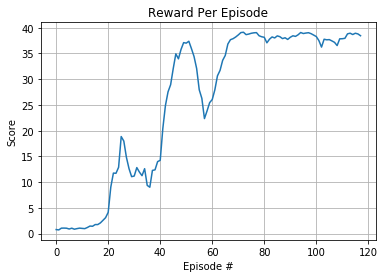

In [7]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(train_scores)), train_scores)
plt.title('Reward Per Episode')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.grid(True)
plt.show()

### 5. Test the Trained Agents
Now that the agents have been trained, the environment can be reset and set into test mode using the `train_mode=False` flag. Using the the best weights for the agents we can run the Unity environment to test the agents.

In [ ]:
# Initialize environment
env_info = env.reset(train_mode=False)[brain_name]

# Set number of actions and agents
action_size = brain.vector_action_space_size # 4
num_agents = len(env_info.agents) # 20

# Set states for each agent
states = env_info.vector_observations
state_size = states.shape[1] # 33

# Create the agent
agent = Agent(state_size, action_size, seed=0, n_agents=num_agents)
test_scores = np.zeros(num_agents)

# Set best device available
if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

# Load best agent weights
agent.actor_local.load_state_dict(torch.load('actor_checkpoint.pth', map_location=map_location))
agent.critic_local.load_state_dict(torch.load('critic_checkpoint.pth', map_location=map_location))

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 6. Close the Environment
When finished, we close the environment.

In [9]:
env.close()